https://finance.yahoo.com/commodities/

https://gsnchez.com/blog/article/Optimizacion-algoritmica-de-carteras-con-markowitz

Importamos las librerias necesarias.

In [27]:
import pandas as pd
import numpy as np
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from time import time
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import ConstantKernel, WhiteKernel, RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor
import warnings
warnings.filterwarnings("ignore")

Descargamos el dataset a estudiar.

In [28]:
natural_gas = wb.DataReader('NG=F', data_source='yahoo', start='1900-1-1')

In [29]:
natural_gas.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-08-30,4.815,4.63,4.65,4.805,34954.0,4.805
2000-08-31,4.870,4.74,4.82,4.780,25787.0,4.780
2000-09-01,4.860,4.75,4.75,4.835,113.0,4.835
2000-09-05,4.975,4.84,4.85,4.960,26096.0,4.960
2000-09-06,5.110,4.96,4.99,5.065,32764.0,5.065


Transformamos el dataset a series de precios (Adj Close) anuales.

In [30]:
starts, ends = [], []
for i in range(1,22):
    starts.append('20{:02d}-01-01'.format(i))
    ends.append('20{:02d}-12-31'.format(i))

In [31]:
sd = np.std(natural_gas['Adj Close'].values)
natural_gas_years = pd.DataFrame()
for start, end in zip(starts, ends):
    s, v = [None] * 253, natural_gas['Adj Close'][start:end].values
    s[:len(v)] = v
    natural_gas_years[end[:4]] = s

In [32]:
natural_gas_years.head()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,8.364,2.465,5.251,6.827,5.790,10.626,6.299,7.850,5.971,5.884,...,2.993,3.233,4.321,3.003,2.334,3.327,3.056,2.958,2.122,2.581
1,8.220,2.268,5.344,7.082,5.902,10.197,6.163,7.674,6.072,5.637,...,3.096,3.198,4.304,2.882,2.325,3.267,3.008,2.945,2.130,2.702
2,9.000,2.275,4.935,6.878,5.833,9.499,6.162,7.841,5.983,6.009,...,2.980,3.287,4.306,2.938,2.267,3.273,2.880,3.044,2.135,2.716
3,9.250,2.272,5.127,7.094,6.049,9.632,6.184,7.879,5.872,5.806,...,3.062,3.266,4.299,2.871,2.382,3.285,2.795,2.944,2.162,2.729
4,9.700,2.281,5.161,7.287,6.001,9.390,6.378,7.967,5.583,5.749,...,3.011,3.218,4.216,2.927,2.472,3.103,2.835,2.967,2.141,2.700


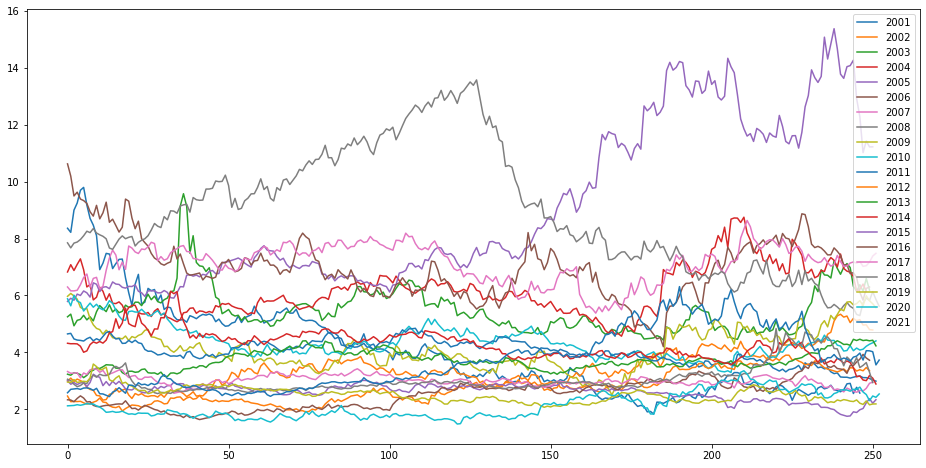

In [33]:
natural_gas_plot = natural_gas_years.plot(figsize=(16,8), legend=True, linewidth=1.5)

Obtenemos las matrices X e y. La matriz X tiene como columnas la variable año actual y la variable dia actual. La matriz y tiene los precios correspondientes a cada fila de X.

In [34]:
days = natural_gas_years.index.values
years = [int(year) for year in natural_gas_years.columns.values]

X = pd.DataFrame(columns=['year', 'date', 'day_sin', 'day_cos', 'y-1'])
y, i, n = np.array([None] * len(years) * len(days)), 0, 0
for year in years:
    for day in days:
        X.loc[i, 'year'] = year
        X.loc[i, 'day_sin'] = np.sin(day * 2 * np.pi / 252)
        X.loc[i, 'day_cos'] = np.cos(day * 2 * np.pi / 252)
        if year > years[0]:
            X.loc[i, 'y-1'] = y[n]
            n += 1
        y[i] = natural_gas_years[str(year)].values[day]
        i += 1

mask = ~np.isnan(list(y)) & ~np.isnan(list(X['y-1'].values))
X = X.loc[mask,:].reset_index(drop=True)
X['date'] = X.index
y = y[mask]

Iteramos entrenando un GP con kernel rbf sobre los años anteriores a n y el primer trimeste de n, y predecimos el resto del año n para n entre 2016 y 2021.

Predicting year 2011 with data from 2003 to 2010
Elapsed time: 54.081s
Log-marginal-likelihood: 1523.585


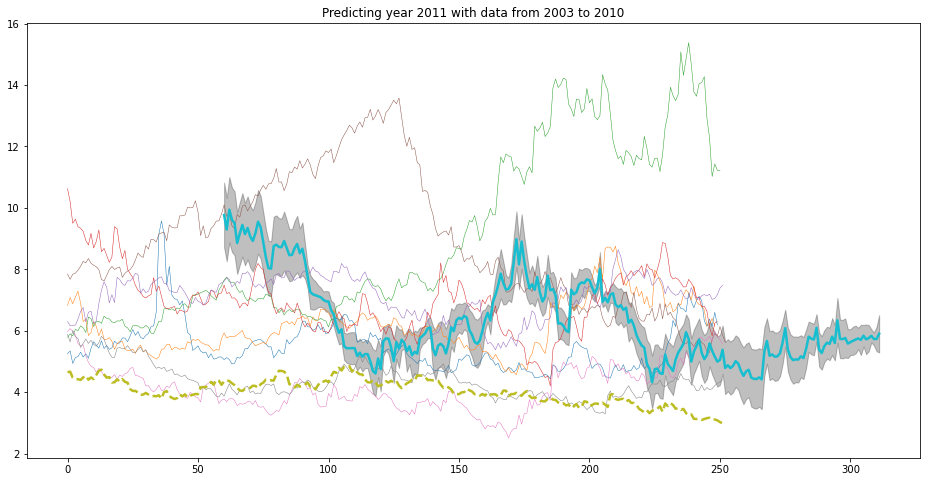

In [35]:
years_pred, days_pred, n_years, i = range(2011, 2012), 60, 8, 0
for year_pred in years_pred:
    
    title = 'Predicting year {} with data from {} to {}'.format(year_pred, year_pred - n_years, year_pred - 1)
    print(title)
    day_pred, i = i * 253 + days_pred, i + 1
    
    X_train = X.loc[((X['year'] >= year_pred - n_years) & (X['year'] < year_pred)) | ((X['year'] == year_pred) & (X['date'] <= day_pred))][['date', 'day_sin', 'day_cos', 'y-1']]
    X_train = pd.DataFrame(StandardScaler().fit_transform(X_train), columns=['date', 'day_sin', 'day_cos', 'y-1'])
    y_train = y[X_train.index]
    
    X_test = X.loc[(X['year'] == year_pred) & (X['date'] > day_pred)][['date', 'day_sin', 'day_cos', 'y-1']]
    X_test = pd.DataFrame(StandardScaler().fit_transform(X_test), columns=['date', 'day_sin', 'day_cos', 'y-1'])
    y_test = y[X_test.index]
    
    kernel = ConstantKernel() * RationalQuadratic() + ConstantKernel() * WhiteKernel()
    gp = GaussianProcessRegressor(kernel=kernel,
                                  normalize_y=True,
                                  n_restarts_optimizer=1,
                                  random_state=2)
    t0 = time()
    gp.fit(X_train, y_train)
    print("Elapsed time: %0.3fs" % (time() - t0))
    print("Log-marginal-likelihood: %.3f" % gp.log_marginal_likelihood(gp.kernel_.theta))
    
    y_pred, y_std = gp.predict(X_test, return_std=True)
    
    hco = natural_gas_years.loc[:,'{}-01-01'.format(year_pred - n_years - 1):'{}-01-01'.format(year_pred - 1)].plot(figsize=(16,8), legend=False, linewidth=.5, title=title)
    p = hco.plot(natural_gas_years[str(year_pred)], linewidth=2.5, linestyle='--')
    y_plot, y_plot[days_pred:] = [None] * (len(y_pred) + days_pred), y_pred
    p = hco.plot(y_plot, linewidth=2.5)
    p = hco.fill_between(range(days_pred, len(y_pred) + days_pred), y_pred - y_std, y_pred + y_std, alpha=0.25, color='k')
    f = hco.get_figure()
    f.savefig('Figures/{}.png'.format(year_pred))